## xcube Data Cube Generator with custom Processing

This notebook provides a walk-through demonstrating how to use a data cube generator in combination with _custom processing_.

We first use the [Local Data Cube Generator](./2_local.ipynb) to generate the source cube that will be used as test data for the algorithm development.
Towards completion of development the the [Data Cube Generator Service](./3_service.ipynb) is used to process a larger dataset with the algorithm executed server-side.

In [1]:
from xcube.core.gen2 import LocalCubeGenerator
from xcube.core.gen2 import CubeGeneratorRequest

from xcube.core.compute import compute_cube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry

The first example represents a simple conversion from a local NetCDF dataset (`input_config`) into a
local Zarr dataset (`output_config`). As we only want a copy we do not want to specify any target 
cube parameters (`cube_config`).

This is how a _cube generator request_ looks as a (JSON) dictionary:

In [2]:
request_json = {
    "input_config": {
        "store_id": "sentinelhub",
        "data_id": "S2L2A",
        "open_params": {
            "time_tolerance": "30m"
        }
    },
    "cube_config": {
       "variable_names": ['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
       "tile_size": [512, 512],
       "bbox": [10.37, 54.28, 10.52, 54.33],
       "spatial_res":  0.00018,   # = 20.038 meters in degree
       "time_range": ['2019-07-21', '2019-09-21'],       
       "time_period": "4D",
    },
    "output_config": {
        "store_id": "directory",
        "store_params": {
            "base_dir": "."
        },
        "replace": True,
        "data_id": "cube.zarr"
    }
}

Validate `request_json` and convert into a `CubeGeneratorRequest` object:

In [3]:
request = CubeGeneratorRequest.from_dict(request_json)
request

Instantiate the generator object:

In [4]:
gen = LocalCubeGenerator(request)

Get some information about the cube that would be generated by `gen`:

In [5]:
cube_info = gen.get_cube_info()
cube_info

Now perform the actual cube generation:

In [6]:
cube_id = gen.generate_cube()
cube_id

'cube.zarr'

Let's open the generated cube:

In [7]:
import xarray as xr
source_cube = xr.open_zarr(cube_id)
source_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2021-04-22T18:44:06.714149
    geospatial_lat_max:        54.330040000000004
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lon_min:        10.37
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P64DT0H0M0S
    time_coverage_end:         2019-09-23T00:00:00+00:00
    time_coverage_resolution:  P4DT0H0M0S
    time_coverage_start:       2019-07-21T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

In [8]:
scene_classif = MaskSet(source_cube.SCL)
scene_classif

Flag name,Mask,Value
no_data,None,0
saturated_or_defective,None,1
dark_area_pixels,None,2
cloud_shadows,None,3
vegetation,None,4
bare_soils,None,5
water,None,6
clouds_low_probability_or_unclassified,None,7
clouds_medium_probability,None,8
clouds_high_probability,None,9


In [9]:
scene_classif.water

<xarray.DataArray 'water' (time: 16, lat: 278, lon: 1024)>
dask.array<where, shape=(16, 278, 1024), dtype=uint8, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21

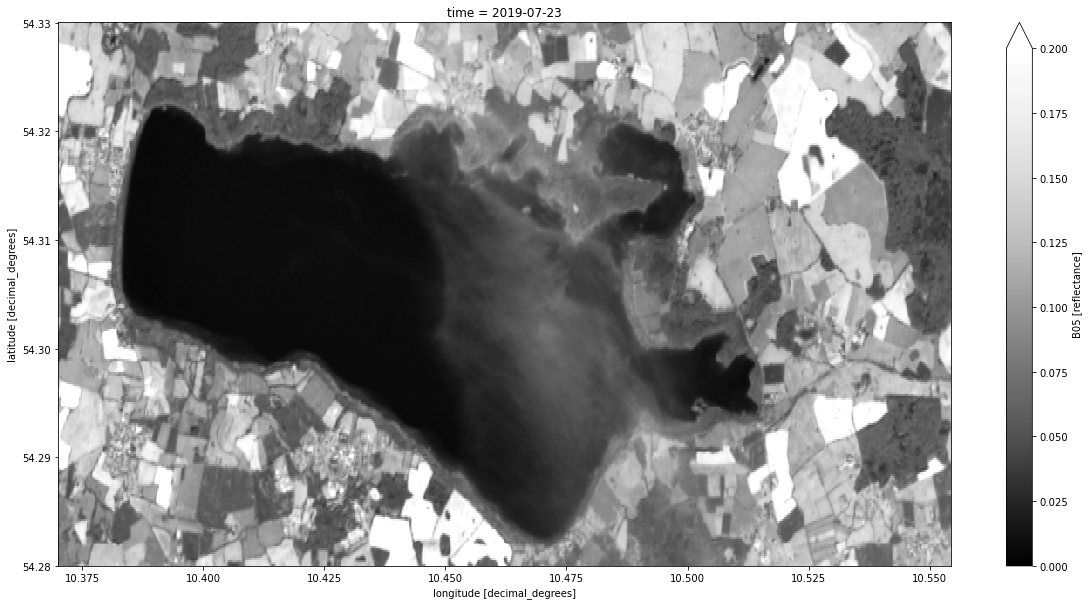

In [10]:
source_cube.B05.isel(time=0).plot.imshow(figsize=(20, 10), vmin=0, vmax=0.2, cmap='Greys_r')

_This is a work in progress. More material will follow in an upcoming xcube release._

In [11]:
def compute_mci_var(b_from, b_peek, b_to, input_params, dim_coords):
    # The first three arguments are chunks of the three input variables we define below. 
    # You can name them as you like. They are pure 3D numpy arrays.
    
    # The 'input_params' argument is a standard parameter that we define in the call below.
    wlen_from = input_params['wlen_from']
    wlen_peek = input_params['wlen_peek']
    wlen_to = input_params['wlen_to']
    
    # The 'dim_coords' argument is optional and provides the coordinate values for all dimension 
    # of the current chunk. We don't use it here, but for many algorithms this is important 
    # information (e.g. looking up aux data).
    lon, lat = (dim_coords[dim] for dim in ('lon', 'lat'))
    # print('dim_coords from', lon[0], lat[0], 'to', lon[-1], lat[-1])
    
    # You can use any popular data packages such as numpy, scipy, dask here,
    # or we can use ML packages such as scikitlearn!
    # For simplity, we do some very simple array math here:

    f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
    mci = (b_peek - b_from) - f * (b_to - b_from)

    return mci

In [12]:
def compute_mci_cube(source_cube, **params):
    
    scene_classif = MaskSet(source_cube.SCL)    
    water_cube = source_cube.where(scene_classif.water)
    
    
    input_params = dict(wlen_from=water_cube.B04.attrs['wavelength'],
                        wlen_peek=water_cube.B05.attrs['wavelength'],
                        wlen_to=water_cube.B06.attrs['wavelength'])
    
    mci_cube = compute_cube(compute_mci_var, 
                            water_cube, 
                            input_var_names=['B04', 'B05', 'B06'], 
                            input_params=input_params, 
                            output_var_name='mci')

    mci_cube.mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
    mci_cube.mci.attrs['units'] = 'unitless'

    return mci_cube    

In [13]:
mci_cube = compute_mci_cube(source_cube)
mci_cube

d:\projects\xcube\xcube\core\compute.py:137: UserWarning: weird index_chunk of size 0 received!
  warnings.warn(f"weird index_chunk of size {index_chunk.size} received!")


<xarray.Dataset>
Dimensions:  (lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Data variables:
    mci      (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>

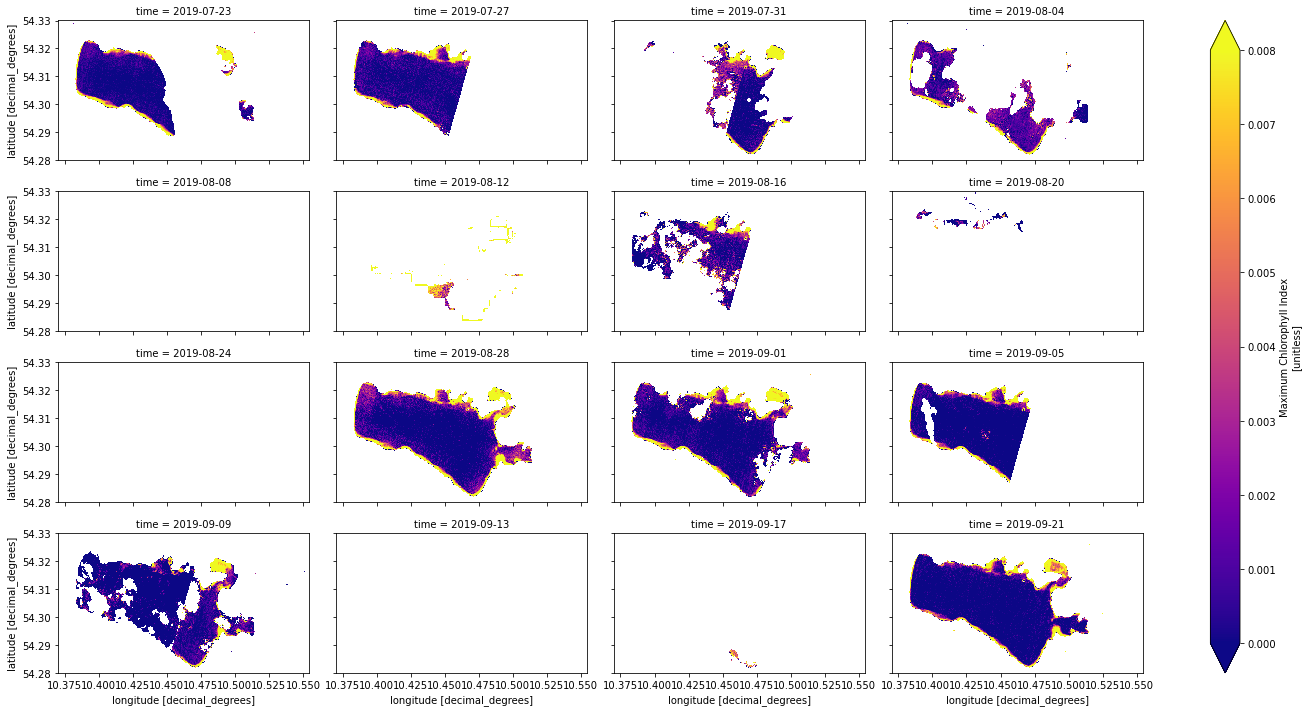

In [14]:
mci_cube.mci.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=0.008, cmap='plasma', figsize=(20, 10))

## Algorithm Deployment and actual Processing Service Testing

Now that the algorithm provides the expected result:

1. the provider puts the code into a GitHub repository.
2. the provider registers the algorithm.

```python
algo_service = AlgoService(algo_service_config)
algo_service.push_algo({
    "code_config": {
        "type": "GitHub",
        "metadata": {
            "name": "mci",
            "version": "0.0.0.dev0",
            "labels": {
                # Put any label selectors here
            }    
        },    
        "spec": {
            "gh_repo": "<github-repo-uri>",
            "gh_token": "<github-token>",
            "processor": "<module-path>:compute_mci_cube",
            "processor_params_schema": {
                # A JSON Schema is used to describe parameters
                "type": ["object", "null"],
                "properties": {
                    # Put any processor parameters here    
                },
                "additionalProperties": False
            }
        }
    }
})
``` 

We can now update the processing request so that the processing is done by the service:

```python
request_json.update({
    "cube_config": {
       "time_range": ['2010-01-01', '2021-01-01'],       
    },
    "code_config": {
        "processor_ref": "mci:0.0.0.dev0",
        "processor_params": {
            # Any extra params here...
        }
    }
})

request = CubeGeneratorRequest.from_dict(request_json)
```

For the request generate the service client:

```python
gen = CubeGeneratorService(request, service_config)
```

Estimate sizes and cost

```python
mci_cube_info = gen.get_cube_info()
mci_cube_info
```

Generate the actual cube

```python
with gen.progress_monitor():
    mci_cube = gen.generate_cube()

mci_cube
```


_This is a work in progress. More material will follow in an upcoming xcube release._